<a href="https://colab.research.google.com/github/IlyaTyagin/MLTSA22_ITyagin/blob/main/HW8/HW8_Ilya_Tyagin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW8 Ilya Tyagin

In [3]:
import pandas as pd
import numpy as np
import pylab as pl
import random
from scipy import stats
from tqdm import tqdm
from collections import defaultdict
import pickle

from scipy import interpolate

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import glob
import pylab as pl
from PIL import Image

tqdm.pandas()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pl.rcParams['figure.figsize'] = (15, 10)

## Opening and prepairing the dataset

In [ ]:
lcvs = pd.read_csv(
    """https://zenodo.org/record/2539456/files/plasticc_train_lightcurves.csv.gz?download=1""", 
    compression='gzip'
    )

In [ ]:
lcvs

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1
...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0
1421701,130779836,60560.0459,1,14.894439,18.947685,0
1421702,130779836,60571.0225,5,30.593130,50.695290,0
1421703,130779836,60585.9974,4,-23.471439,44.819859,0


In [ ]:
# Making sure that all objects have the same number of measurements
lcvs[:][['object_id', 'passband']].drop_duplicates()['passband'].value_counts()

2    7848
1    7848
3    7848
4    7848
5    7848
0    7848
Name: passband, dtype: int64

In [ ]:
lcvs.rename(
    columns={
        'detected_bool': 'detected'
    },
    inplace=True,
  )

In [ ]:
metadata = pd.read_csv(
    """https://zenodo.org/record/2539456/files/plasticc_train_metadata.csv.gz?download=1""", 
    compression='gzip'
    )

### standardize and normalize flux

In [ ]:
def agg_norm_flux(x):
  """ func that standardizes flux and flux_err values.
  
  x - pandas groupby object (over obj_id and passband)
  """
  x['flux_norm'] = (
      np.array(x['flux']) - np.mean(x['flux'])
      )/np.std(x['flux'])
  x['flux_err_norm']= (
    np.array(x['flux_err']) - np.mean(x['flux_err'])
    )/np.std(x['flux_err'])
  return x

In [ ]:
lcvs_norm = lcvs.groupby(
  ["object_id", "passband"]
).progress_apply(agg_norm_flux)

100%|██████████| 47088/47088 [02:05<00:00, 376.32it/s]


In [ ]:
lcvs_norm[['object_id', 'flux_norm']][:1000].groupby('object_id').progress_apply(lambda x: list(x['flux_norm']))

100%|██████████| 3/3 [00:00<00:00, 790.58it/s]


object_id
615    [-0.9101976693636594, -0.722009849452599, -1.0...
713    [1.7318442352186199, 1.5252944052923676, 1.198...
730    [-0.22222138521234783, 1.217919660206111, -0.0...
dtype: object

## Common time frame and measurements interpolation

For interpolation (and EXTRApolation for some measurements) we are gonna use qubic splines. They works reasonably fine, are fast and do not require any hyperparameter tuning. For extrapolated values, we're using boundary measurements, otherwise the curve behaves quite unpredictably.

In [ ]:
def comm_time_frame(x):
  """ func that for each object choose the timestamps of the first observation and set it to 0.
  
  x - pandas groupby object (over obj_id and passband)
  """
  x_min = x['mjd'].min()
  x['mjd_0'] = x['mjd'] - x_min
  return x

In [ ]:
lcvs_norm_mjd_0 = lcvs_norm.groupby(
  ["object_id", "passband"]
).progress_apply(comm_time_frame)

100%|██████████| 47088/47088 [01:14<00:00, 634.01it/s] 


In [ ]:
lcvs_norm_mjd_0.to_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_df.pkl'
)

In [ ]:
lcvs_norm_mjd_0 = pd.read_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_df.pkl'
)

In [ ]:
lcvs_norm_mjd_0

,object_id,mjd,passband,flux,flux_err,detected,flux_norm,flux_err_norm,mjd_0
0,615,59750.4229,2,-544.810303,3.622952,1,-0.910198,0.422316,0.0000
1,615,59750.4306,1,-816.434326,5.553370,1,-0.722010,0.452984,0.0000
2,615,59750.4383,3,-471.385529,3.801213,1,-1.053414,1.338867,0.0000
3,615,59750.4450,4,-388.984985,11.395031,1,-1.151251,7.037395,0.0000
4,615,59752.4070,2,-681.858887,4.041204,1,-1.213953,1.150246,1.9841
...,...,...,...,...,...,...,...,...,...
1421700,130779836,60555.9838,4,-39.881969,46.477093,0,-0.326977,-0.125639,833.6750
1421701,130779836,60560.0459,1,14.894439,18.947685,0,-0.619476,-0.612220,806.8968
1421702,130779836,60571.0225,5,30.593130,50.695290,0,-0.486677,-0.474481,855.6906
1421703,130779836,60585.9974,4,-23.471439,44.819859,0,-0.325456,-0.147321,863.6886


In [ ]:
lcvs_norm_mjd_0_listed_df = lcvs_norm_mjd_0.groupby(
    ['object_id', 'passband']
).agg(
    {
      "flux_norm": [list],
      "mjd_0": [list, "max"]
    }
)

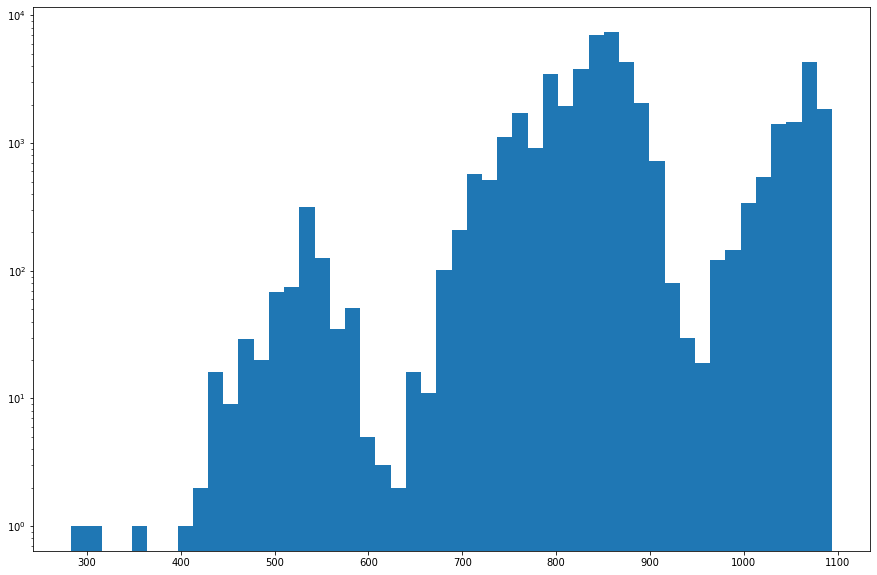

In [ ]:
plt.hist(
    lcvs_norm_mjd_0_listed_df[('mjd_0', 'max')].values, 
    log=True, 
    bins=50
)
plt.show()

Plot: histogram of upper timeframe across all measurements. As we can see, measurements were taken differently (in terms of duration, if we count from 0th moment in time for each `object_id`), so in many cases we need to extrapolate their TSs significantly.

In [ ]:
lcvs_norm_mjd_0_listed_filt_df = lcvs_norm_mjd_0_listed_df

### Interpolation (and EXTRApolation)

In [ ]:
upper_boundary = lcvs_norm_mjd_0_listed_filt_df[('mjd_0', 'max')].max()
upper_boundary

1094.0023999999976

In [ ]:
steps = 500

In [ ]:
ts_grid = np.arange(
  start=0,
  stop=upper_boundary,
  step=upper_boundary/(steps)
)
ts_grid.shape

(501,)

In [ ]:
current_obj_df = lcvs_norm_mjd_0[
  (lcvs_norm_mjd_0['object_id'] == 130779836) & (lcvs_norm_mjd_0['passband'] == 3)
][['mjd_0', 'flux_norm']]

In [4]:
interpolate.InterpolatedUnivariateSpline?

In [ ]:
f = interpolate.InterpolatedUnivariateSpline(
  x=current_obj_df['mjd_0'], 
  y=current_obj_df['flux_norm'], 
  ext=3, #type of extrapolation, 3 - take boundary values, for stability
  k=3, # degree
)

In [ ]:
ynew = f(ts_grid)
len(ts_grid), len(ynew)

(501, 501)

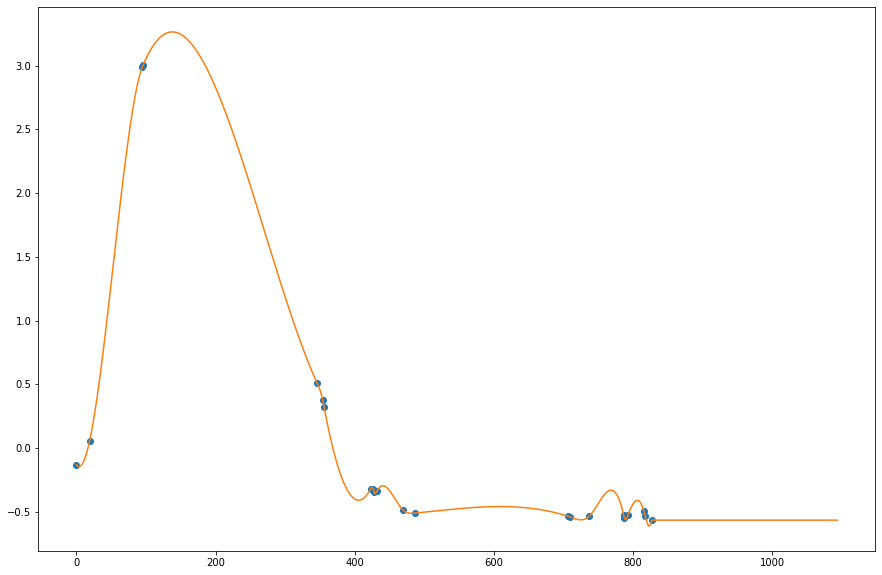

In [ ]:
#ynew = f(xnew)   # use interpolation function returned by `interp1d`

plt.plot(current_obj_df['mjd_0'], current_obj_df['flux_norm'], 'o')
plt.plot(ts_grid, ynew, '-')

plt.show()

Plot: cubic interpolation of a sample curve.
Looks okay, but min and max values are smoothified at the point that they don't correspond to real min and max measurements. In addition, the curve "smoothness" add some humps and downs, which probably wouldn't be presented on real measurements. But we can only guess...

In [ ]:
def apply_interpolate(x_df):
  
  # adding this condition to filter off completely broken measurements
  if len(x_df[('flux_norm', 'list')]) > 3:

    f = interpolate.InterpolatedUnivariateSpline(
      x=x_df[('mjd_0', 'list')], 
      y=x_df[('flux_norm', 'list')], 
      ext=3,
      k=3,
    )

    x_df['x_int'] = ts_grid
    x_df['y_int'] = f(ts_grid)

    return x_df
  else:
    return np.NaN

In [ ]:
lcvs_norm_mjd_0_listed_filt_df

flux_norm  \
                                                                 list   
object_id passband                                                      
615       0         [0.12168401013019357, 0.5117859687025709, -0.0...   
          1         [-0.722009849452599, -1.1327242018713475, -0.7...   
          2         [-0.9101976693636594, -1.213953005901712, -0.9...   
          3         [-1.0534136159611334, -1.2145134548584586, -1....   
          4         [-1.1512509928608998, -1.1667905640994658, -1....   
...                                                               ...   
130779836 1         [0.029554350344488892, 2.061022510442743, 2.26...   
          2         [-0.06665006236995767, 0.2917977983398143, 0.3...   
          3         [-0.1311130853347585, 0.055563195049427194, 2....   
          4         [-0.24807573584838163, -0.24996709229370795, -...   
          5         [-0.40171719985261006, -0.22040931975168554, -...   

                                                                mjd_0  \
                                                                 list   
object_id passband                                                      
615       0         [0.0, 0.9515000000028522, 1.949399999997695, 2...   
          1         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          2         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          3         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          4         [0.0, 1.9884000000020023, 16.87829999999667, 1...   
...                                                               ...   
130779836 1         [0.0, 57.021600000000035, 58.87399999999616, 3...   
          2         [0.0, 29.015299999999115, 31.978799999997136, ...   
          3         [0.0, 18.812799999999697, 94.59199999999691, 9...   
          4         [0.0, 6.122499999997672, 46.83110000000306, 53...   
          5         [0.0, 56.86130000000412, 61.9635000000053, 83....   

                              
                         max  
object_id passband            
615       0         797.8763  
          1         873.7530  
          2         873.7531  
          3         873.7530  
          4         873.7572  
...                      ...  
130779836 1         806.8968  
          2         727.0004  
          3         826.7340  
          4         863.6886  
          5         855.6906  

[47088 rows x 3 columns]

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df = lcvs_norm_mjd_0_listed_filt_df.progress_apply(
    apply_interpolate, 
    axis=1
)

100%|██████████| 47088/47088 [02:59<00:00, 261.98it/s]


In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df

flux_norm  \
                                                                 list   
object_id passband                                                      
615       0         [0.12168401013019357, 0.5117859687025709, -0.0...   
          1         [-0.722009849452599, -1.1327242018713475, -0.7...   
          2         [-0.9101976693636594, -1.213953005901712, -0.9...   
          3         [-1.0534136159611334, -1.2145134548584586, -1....   
          4         [-1.1512509928608998, -1.1667905640994658, -1....   
...                                                               ...   
130779836 1         [0.029554350344488892, 2.061022510442743, 2.26...   
          2         [-0.06665006236995767, 0.2917977983398143, 0.3...   
          3         [-0.1311130853347585, 0.055563195049427194, 2....   
          4         [-0.24807573584838163, -0.24996709229370795, -...   
          5         [-0.40171719985261006, -0.22040931975168554, -...   

                                                                mjd_0  \
                                                                 list   
object_id passband                                                      
615       0         [0.0, 0.9515000000028522, 1.949399999997695, 2...   
          1         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          2         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          3         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          4         [0.0, 1.9884000000020023, 16.87829999999667, 1...   
...                                                               ...   
130779836 1         [0.0, 57.021600000000035, 58.87399999999616, 3...   
          2         [0.0, 29.015299999999115, 31.978799999997136, ...   
          3         [0.0, 18.812799999999697, 94.59199999999691, 9...   
          4         [0.0, 6.122499999997672, 46.83110000000306, 53...   
          5         [0.0, 56.86130000000412, 61.9635000000053, 83....   

                              \
                         max   
object_id passband             
615       0         797.8763   
          1         873.7530   
          2         873.7531   
          3         873.7530   
          4         873.7572   
...                      ...   
130779836 1         806.8968   
          2         727.0004   
          3         826.7340   
          4         863.6886   
          5         855.6906   

                                                                x_int  \
                                                                        
object_id passband                                                      
615       0         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          1         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          2         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          3         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          4         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
...                                                               ...   
130779836 1         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          2         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          3         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          4         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          5         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   

                                                                y_int  
                                                                       
object_id passband                                                     
615       0         [0.12168401013019357, -0.25449026243119477, -1...  
          1         [-0.7220098494525989, -1.1635652397779463, -1....  
          2         [-0.9101976693636596, -1.2368096609818569, -1....  
          3         [-1.0534136159611336, -1.226785270794583, -1.3...  
          4         [-1.1512509928609,

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df = (
  lcvs_norm_mjd_0_listed_filt_interpolated_df
  .dropna()
)

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df.dropna().index.get_level_values(1).value_counts()

2    7848
3    7848
4    7848
5    7848
1    7845
0    7841
Name: passband, dtype: int64

In [ ]:
band_counts_dict = (
  lcvs_norm_mjd_0_listed_filt_interpolated_df
    .index
    .get_level_values(0)
    .value_counts()
    .to_dict()
)

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df.index.get_level_values(1).values

array([0, 1, 2, ..., 3, 4, 5])

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df = (
  lcvs_norm_mjd_0_listed_filt_interpolated_df.loc[
    (lcvs_norm_mjd_0_listed_filt_interpolated_df
      .index
      .get_level_values(0).drop_duplicates()[
        (lcvs_norm_mjd_0_listed_filt_interpolated_df
          .index
          .get_level_values(0)
          .value_counts()) == 6
      ])
  ,:]
)

#### Saving results

In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_df.to_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_listed_filt_interpolated_df.pkl'
)
lcvs_norm_mjd_0.to_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_df.pkl'
)

## Flattening TS

To flatten each 6-band TS, we're going to use `.flatten` method from `numpy`, which puts measurements like: `B1|B2|...`. I also tried to calculate mean value across all bands to perform some kind of reduction, but the autoencoder performed too badly, so I had to redo it with flattening.

In [50]:
lcvs_norm_mjd_0_listed_filt_interpolated_df = (
    pd.read_pickle('/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_listed_filt_interpolated_df.pkl')
)

In [51]:
lcvs_norm_mjd_0_listed_filt_interpolated_df

flux_norm  \
                                                                 list   
object_id passband                                                      
615       0         [0.12168401013019357, 0.5117859687025709, -0.0...   
          1         [-0.722009849452599, -1.1327242018713475, -0.7...   
          2         [-0.9101976693636594, -1.213953005901712, -0.9...   
          3         [-1.0534136159611334, -1.2145134548584586, -1....   
          4         [-1.1512509928608998, -1.1667905640994658, -1....   
...                                                               ...   
130678775 1         [0.1777228855650024, -0.06676481102812624, -0....   
          2         [-0.37517352615846744, -0.6366282673001353, 1....   
          3         [-0.09045866783426494, -0.6547917719878834, 0....   
          4         [-1.4643440932901008, 0.034872827111954136, 0....   
          5         [0.213944562918174, -0.36945624007871475, -0.4...   

                                                                mjd_0  \
                                                                 list   
object_id passband                                                      
615       0         [0.0, 0.9515000000028522, 1.949399999997695, 2...   
          1         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          2         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          3         [0.0, 1.9841000000014901, 16.873899999998685, ...   
          4         [0.0, 1.9884000000020023, 16.87829999999667, 1...   
...                                                               ...   
130678775 1         [0.0, 1.0311000000001513, 146.81519999999728, ...   
          2         [0.0, 0.9896999999982654, 22.896799999994982, ...   
          3         [0.0, 41.935599999997066, 305.98909999999887, ...   
          4         [0.0, 29.903800000000047, 30.70520000000397, 5...   
          5         [0.0, 6.009799999999814, 9.005199999999604, 66...   

                               \
                          max   
object_id passband              
615       0          797.8763   
          1          873.7530   
          2          873.7531   
          3          873.7530   
          4          873.7572   
...                       ...   
130678775 1          743.0054   
          2          765.9435   
          3         1075.9097   
          4         1061.9119   
          5         1071.0836   

                                                                x_int  \
                                                                        
object_id passband                                                      
615       0         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          1         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          2         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          3         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          4         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
...                                                               ...   
130678775 1         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          2         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          3         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          4         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   
          5         [0.0, 2.188004799999995, 4.37600959999999, 6.5...   

                                                                y_int  
                                                                       
object_id passband                                                     
615       0         [0.12168401013019357, -0.25449026243119477, -1...  
          1         [-0.7220098494525989, -1.1635652397779463, -1....  
          2         [-0.9101976693636596, -1.2368096609818569, -1....  
          3         [-1.0534136159611336, -1.226785270794583, -1.3...  
          4         [-1.

In [52]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df = (
    lcvs_norm_mjd_0_listed_filt_interpolated_df
    .groupby(level=0)
    .progress_apply(
      lambda x: np.array(list(x['y_int']))
    )
    .to_frame()
    .rename(columns={0:'bands_matrix'})
)

100%|██████████| 7838/7838 [00:14<00:00, 546.27it/s]


In [ ]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df['bands_matrix'].apply(
    lambda x: x.shape
).value_counts()

(6, 501)    7828
(5, 501)      10
Name: bands_matrix, dtype: int64

In [53]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df['autoenc_inp'] = (
    lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df['bands_matrix']
    .progress_apply(lambda x: x.flatten())
)

100%|██████████| 7838/7838 [00:00<00:00, 87529.53it/s]


In [54]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df

,bands_matrix,autoenc_inp
object_id,,
615,"[[0.12168401013019357, -0.25449026243119477, -...","[0.12168401013019357, -0.25449026243119477, -1..."
713,"[[1.4142344303181167, -9.51498013507562, -16.1...","[1.4142344303181167, -9.51498013507562, -16.11..."
730,"[[-1.2631932037160947, -1.2829900410479982, 2....","[-1.2631932037160947, -1.2829900410479982, 2.5..."
745,"[[-0.29050587333316463, -0.522121115336005, 0....","[-0.29050587333316463, -0.522121115336005, 0.3..."
1124,"[[-0.43533772652396335, -1.675247806112673, -4...","[-0.43533772652396335, -1.675247806112673, -4...."
...,...,...
130617044,"[[-1.1196605754204523, -1.1020282153245875, -1...","[-1.1196605754204523, -1.1020282153245875, -1...."
130622528,"[[-0.009160573258521367, -0.3060505022969356, ...","[-0.009160573258521367, -0.3060505022969356, -..."
130639669,"[[0.5662405221681167, 0.44521723928386975, 0.3...","[0.5662405221681167, 0.44521723928386975, 0.31..."


In [55]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df = (
  lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df.loc[
    lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df['autoenc_inp'].apply(len) == 3006
  ]
)

In [66]:
lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df.to_pickle(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df.pkl'
)

In [62]:
## saving all data to numpy so we can use it straight away when we do the autoencoder part
all_autoenc_data = np.stack(
  lcvs_norm_mjd_0_listed_filt_interpolated_reduced_df['autoenc_inp'].to_numpy()
)

In [68]:
np.save(
    '/content/drive/MyDrive/Classes/22S-PHYS-667/HW8/all_autoenc_data.npy',
    all_autoenc_data
)